In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from keras import Model, Input 
from keras.preprocessing import image
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from mpl_toolkits import mplot3d
from sklearn import metrics
import glob
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

In [ ]:
def PlotBar(ax,type_search,mean, params):
  columns_list = ['Batch_Epoch','SGD','RMSprop','Adadelta','Adam']
  opt_score = [['B8E2',0,0,0,0],['B8E4',0,0,0,0],['B8E6',0,0,0,0],['B16E2',0,0,0,0],
               ['B16E4',0,0,0,0],['B16E6',0,0,0,0],['B32E2',0,0,0,0],['B32E4',0,0,0,0],
               ['B32E6',0,0,0,0]]
  if (type_search == 'Grid Search'): 
    for index in range(len(params)):
      if params[index]['batch_size'] == 8 and params[index]['epochs'] == 2:
        opt_score[0] = MapOptimizer(mean[index],params[index]['optimizer'], opt_score[0])
      elif params[index]['batch_size'] == 8 and params[index]['epochs'] == 4:
        opt_score[1] = MapOptimizer(mean[index],params[index]['optimizer'], opt_score[1])
      elif params[index]['batch_size'] == 8 and params[index]['epochs'] == 6:
        opt_score[2] = MapOptimizer(mean[index],params[index]['optimizer'], opt_score[2])
      elif params[index]['batch_size'] == 16 and params[index]['epochs'] == 2:
        opt_score[3] = MapOptimizer(mean[index],params[index]['optimizer'], opt_score[3])
      elif params[index]['batch_size'] == 16 and params[index]['epochs'] == 4:
        opt_score[4] = MapOptimizer(mean[index],params[index]['optimizer'], opt_score[4])
      elif params[index]['batch_size'] == 16 and params[index]['epochs'] == 6:
        opt_score[5] = MapOptimizer(mean[index],params[index]['optimizer'], opt_score[5])
      elif params[index]['batch_size'] == 32 and params[index]['epochs'] == 2:
        opt_score[6] = MapOptimizer(mean[index],params[index]['optimizer'], opt_score[6])
      elif params[index]['batch_size'] == 32 and params[index]['epochs'] == 4:
        opt_score[7] = MapOptimizer(mean[index],params[index]['optimizer'], opt_score[7])
      elif params[index]['batch_size'] == 32 and params[index]['epochs'] == 6:
        opt_score[8] = MapOptimizer(mean[index],params[index]['optimizer'], opt_score[8])

    df = pd.DataFrame(opt_score,columns = columns_list)
    df.plot(ax=ax,x='Batch_Epoch',
      kind='bar',
      stacked=False,
      title=type_search)

  else :
    # Define data values
    b_e_list =[]
    x_axis = []
    batch_epoch = []
    op1, op2, op3, op4 = [],[],[],[]
    for index in range(len(params)):
      b_e = [params[index]['batch_size'],params[index]['epochs']]
      if b_e not in b_e_list:
        b_e_list.append(b_e)
        batch_epoch.append("B"+str(b_e[0])+"E"+str(b_e[1]))
        x_axis.append(index)
        op1.append(0)
        op2.append(0)
        op3.append(0)
        op4.append(0)
      for i in range(len(b_e_list)):
        if b_e == b_e_list[i]:
          if params[index]['optimizer'] == 'SGD':
            op1[i] = mean[index]
          elif params[index]['optimizer'] == 'RMSprop':
            op2[i] = mean[index]
          elif params[index]['optimizer'] == 'Adadelta':
            op3[i] = mean[index]
          elif params[index]['optimizer'] == 'Adam':
            op4[i] = mean[index]
    # Plot a simple line chart
    ax.plot(x_axis, op1, 'g', label='SGD')
    ax.plot(x_axis, op2, 'r', label='RMSprop')
    ax.plot(x_axis, op3, 'y', label='Adadelta')
    ax.plot(x_axis, op4, 'b', label='Adam')
    ax.title.set_text(type_search)

    plt.xticks(x_axis,batch_epoch)
    plt.legend()

In [ ]:
def MapOptimizer(val, opt, bactch_ep):
  if opt == 'SGD' :
    bactch_ep[1] = val
  elif opt == 'RMSprop' :
    bactch_ep[2] = val
  elif opt == 'Adadelta' :
    bactch_ep[3] = val
  elif opt == 'Adam' :
    bactch_ep[4] = val
    
  return bactch_ep

6.1 Data Preparation from Activity #5.1 – 5.2


<Figure size 432x288 with 0 Axes>

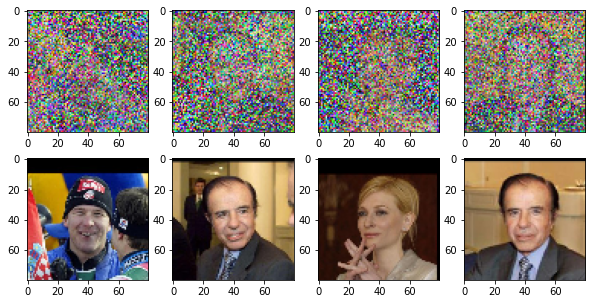

In [ ]:
# List all filename in face image path
filenames= glob.glob(f"/content/drive/MyDrive/Work/CE/Colab/face_mini/**/*.jpg")
height,width,ch = 80,80,3
all_imgs = []
for i in range(len(filenames)):
# for i in range(300):
  # Load image files and Resize (h,w,ch) -> h = w < 100 , ch = 3 (R,G,B)
  img = load_img(filenames[i], grayscale=False, color_mode='rgb', target_size = 
                 (height,width,ch), interpolation="nearest")
  # convert the image to an array
  img = img_to_array(img)
  # Normalized color image
  img = img/255
  all_imgs.append(img)

# convert to numpy array
all_images = np.array(all_imgs)

# split data into train and validation data
x_train, x_test = train_test_split(all_images, random_state=32, test_size=0.3)
x_train, x_val = train_test_split(x_train, random_state=32, test_size=0.3)

# Add Noise กำหนด noise factor (noise level)
# Add noise
noise_factor1 = 0.25
noise_factor2 = 0.5
noise_factor3 = 0.75

noise_factor = noise_factor1
# กำหนด noise parameter
# Noise distribution: normal, Nmean = 0,unit variance (Nstd = 1)
Nmean = 0
Nstd = 1

# np.random.normal to generate normal distribution(gaussian) noise
x_train_noisy = x_train + (noise_factor * np.random.normal(
                loc=Nmean, scale=Nstd, size=x_train.shape))
x_val_noisy = x_val + (noise_factor * np.random.normal(
                loc=Nmean, scale=Nstd, size=x_val.shape))
x_test_noisy = x_test + (noise_factor * np.random.normal(
                loc=Nmean, scale=Nstd, size=x_test.shape) )

#display noisy images
plt.figure()
f1, axarr1 = plt.subplots(2,4,figsize=(10,5)) 
for i in range(4):
  axarr1[0][i].imshow((x_train_noisy[i]* 255).astype(np.uint8))
  axarr1[1][i].imshow((x_train[i]* 255).astype(np.uint8))

6.2 Create_model (Auto encoder)

Model Architecture -> create_model/ KerasRegressor

In [ ]:
# create_model function
def create_model(optimizer='adam'):
  Input_img = Input(shape=(80,80,3))
  # encoder layers
  #encoding architecture
  x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
  x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
  x2 = MaxPool2D( (2, 2))(x2)
  encoded = Conv2D(64, (3, 3), activation='relu',padding='same')(x2)
  # decoding architecture
  x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
  x3 = UpSampling2D((2, 2))(x3)
  x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
  x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
  decoded = Conv2D(3, (3, 3), padding='same')(x1)
  # construct the autoencoder model
  autoencoder = Model(Input_img, decoded)
  autoencoder.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mean_squared_error'])
  return autoencoder
# ประกาศ KERAS ตัวจัดการพารามิเตอร์ของ Model -> ประกาศ Regression module
model = KerasRegressor(build_fn=create_model, epochs=2, 
                       batch_size=16, verbose=0)

6.3 Hyperparameter Tuning

(GridSearchCV(), RandomizedSearchCV())


Best params:  {'batch_size': 8, 'epochs': 6, 'optimizer': 'Adam'}
Best score:  -0.004480072762817144
Best params:  {'optimizer': 'Adam', 'epochs': 7, 'batch_size': 36}
Best score:  -0.005928511964157224


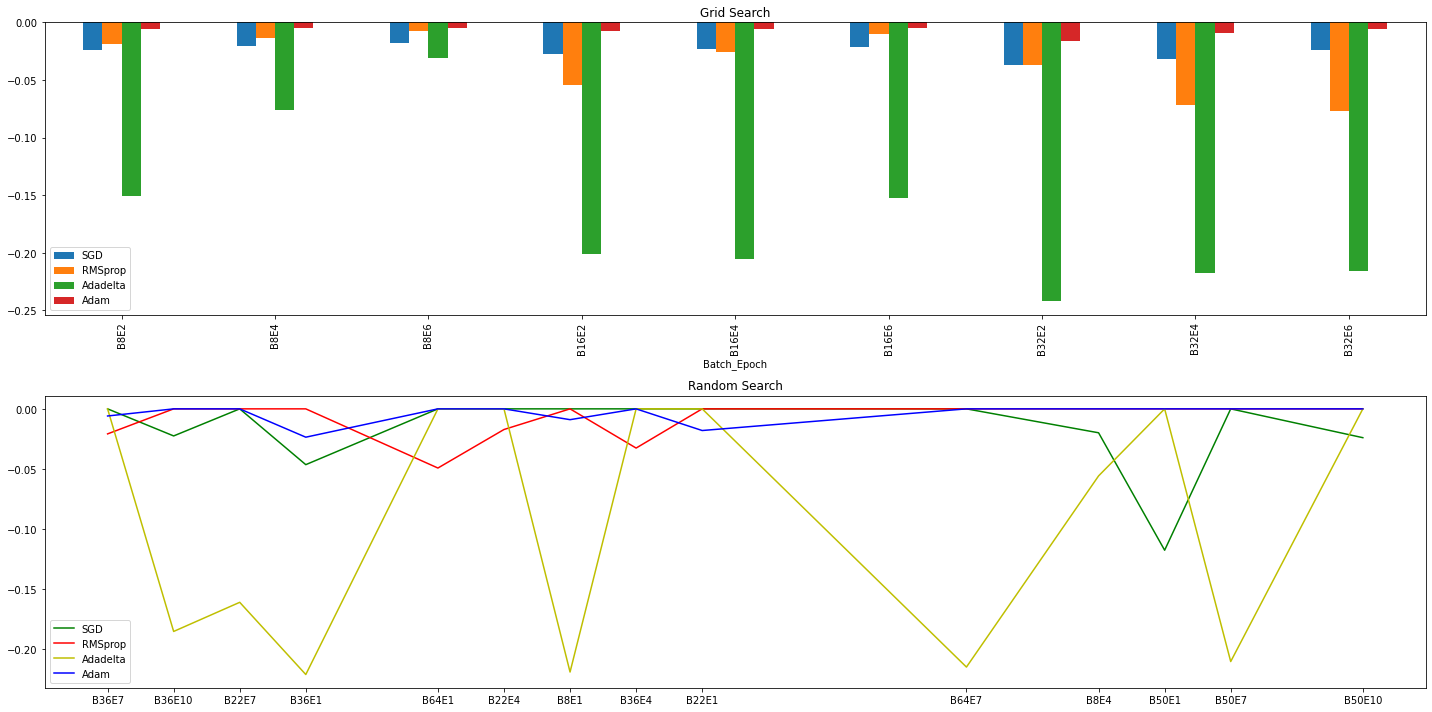

In [ ]:
# 6.3 (a) Create GridSearchCV()
# กำหนด Grid Search parameters -> param_grid
optimizer = ['SGD', 'RMSprop', 'Adadelta', 'Adam']
#define the grid search parameters 
batch_size = [8, 16, 32]
epochs = [2,4,6]
#param_grid = dict(batch_size = batch_size, epochs=epochs)
param_grid = dict(batch_size=batch_size, epochs=epochs, 
                  optimizer=optimizer)
#Grid Search Parameter: 4 x 3 x 3 = 36 combinations

#Declare -> GridSearchCV()
#run grid.fit() -> เก็บ accuracy ของ Cross validation (cv = 2)
grid = GridSearchCV( estimator=model, n_jobs = 1, verbose= 0,
                    cv=2, param_grid = param_grid)
grid_result = grid.fit(x_train_noisy, x_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

print('Best params: ',grid_result.best_params_)
print('Best score: ', grid_result.best_score_)

#6.3 (b) Create RandomizedSearchCV()
# ก ำหนด Grid Search parameters
random_search = {'optimizer': ['SGD', 'RMSprop', 'Adadelta', 'Adam'],
'batch_size': list(np.linspace(8, 64, 5, dtype = int)),
'epochs': list(np.linspace(1, 10, 4, dtype = int))}

grid_rand = RandomizedSearchCV( estimator=model, n_jobs = 1, verbose= 0,
                                cv=2, random_state = 10, #จำนวน random parameters
                                n_iter = 20, param_distributions = random_search)
grid_rand_result = grid_rand.fit(x_train_noisy, x_train)

print('Best params: ',grid_rand_result.best_params_)
print('Best score: ', grid_rand_result.best_score_)

means_2 = grid_rand_result.cv_results_['mean_test_score']
stds_2 = grid_rand_result.cv_results_['std_test_score']
params_2 = grid_rand_result.cv_results_['params']


# Display Statistics view
# Error results from All combinations of grid parameters 
# -> plot() หรือ bar()
fig, (ax1, ax2) = plt.subplots(2, figsize=(20,10))
PlotBar(ax1,'Grid Search',means, params)
PlotBar(ax2,'Random Search',means_2, params_2)
plt.tight_layout()
plt.show()
